In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 150 # this and above will make the figures large enough to read
def loadamesdata():
    import pandas as pd
    
    dataframe = pd.read_table('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',delimiter='\t')

    dataframe = dataframe[dataframe['Gr Liv Area']<4000] # remove the five really large houses
    dataframe = dataframe[dataframe['Sale Condition']=='Normal'] # don't consider partial sales or other types of abnormal sales
    dataframe = dataframe.drop(columns=['Order','PID','Sale Condition'])

    categorynames = []
    iscat = []
    for col in dataframe:
        if dataframe[col].dtype.name == 'object' or col == 'MS SubClass':  # MS SubClass is misinterpreteed as numeric
            dataframe[col] = dataframe[col].astype('category')
            if (dataframe[col].cat.codes<0).any(): # these are -1s to indicate that the value is blank
                categorynames.append(['(blank)']+dataframe[col].cat.categories.tolist())
                dataframe[col] = dataframe[col].cat.codes+1
            else:
                categorynames.append(dataframe[col].cat.categories.tolist())
                dataframe[col] = dataframe[col].cat.codes
            iscat.append(True)
        else:
            categorynames.append(None)
            iscat.append(False)
            
    dataframe['SalePrice'] = dataframe['SalePrice']/1000 # convert to thousands of dollars, to prevent lots of extra 0s from needing to be printed

    return dataframe.to_numpy(), categorynames, iscat, dataframe.columns

(X,categorynames,iscat,featurenames) = loadamesdata()

nfeat = len(iscat)
ncat = sum(iscat[:-1])
nreal = len(iscat)-1-ncat
numcat = (X.max(axis=0)+1).astype(int)  

In [ ]:
# Here are some helper plotting functions you may find useful

# creates a (roughly square) grid of axes that can hold at least n subplots
# returns a flattened (1D) list of these n axes
def getsubplots(n):
    plotrows = int(np.floor(np.sqrt(n)))
    plotcols = int(np.ceil(n/plotrows))

    fig,axs = plt.subplots(plotrows,plotcols)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    axs = axs.flatten()
    for ax in axs[n:]:
        ax.set_axis_off()
    return axs[:n]

# plots a line for the equation y = ax+b for the current axes' limits
def plotline(ax,a,b,clr='blue'):
    xends = np.array(ax.get_xlim())
    yends = xends*a+b
    ret = ax.plot(xends,yends,'-',color=clr)
    ax.set_xlim(xends)
    return ret


In [ ]:


def categorical_mle(input_feature, response):
  v = np.unique(input_feature)

  #Get mu_j for all j of a feature
  category_means = []
  for i in v:
    response_by_category = []
    for j,k in zip(input_feature, np.arange(len(response))):
      if j == i:
        response_by_category.append(response[k])
    category_means.append(np.average(response_by_category))

  #Get variance for the feature
  variance_for_each = []
  for a,b in zip(v, np.arange(len(v))):
    for c,d in zip(input_feature, np.arange(len(response))):
      if c == a:
        variance_for_each.append(np.square(response[d] - category_means[b]))
  overall_variance = np.average(variance_for_each)

  return(category_means, overall_variance)            

In [ ]:
mu_sigma_list = []
for i in range(X[:, iscat].shape[1]):
  mu_sigma_list.append(categorical_mle(X[:, iscat][:, i], X[:, -1]))


sigma_list = [i[1] for i in mu_sigma_list]
mu_list = [i[0] for i in mu_sigma_list]

In [ ]:
keys_sigma = [str(i) for i in range(X[:, iscat].shape[1])]
values_sigma = sigma_list
values_mu = mu_list
dictionary_sigma = dict(zip(keys_sigma, values_sigma))
dictionary_mu = dict(zip(keys_sigma, values_mu))

dictionary_sigma_asc = sorted(dictionary_sigma, key=dictionary_sigma.get)
dictionary_sigma_asc_int = [int(i) for i in dictionary_sigma_asc]

In [ ]:
print("Variance lowest to highest = ")
for i in dictionary_sigma_asc:
  print(dictionary_sigma[i])

Variance lowest to highest = 
2171.451456563512
2648.9477446163974
2689.4794303071276
2727.059793703478
3477.029495374189
3482.9370809404054
3624.9539334619462
3657.01792851644
3718.0771965501617
3821.150241855855
3934.267080093338
4028.7538888396025
4086.0496260393456
4171.394764769556
4176.693263288411
4320.561224361029
4431.767232570817
4468.049750599199
4494.530880197053
4523.433005901535
4529.754570282562
4560.21374169355
4615.635882187205
4648.633090324469
4667.765837697586
4676.680822960063
4731.409155815574
4732.085377743114
4737.960082240721
4741.5830033794755
4768.725891617892
4798.2602452231295
4801.740428375299
4814.481631129006
4826.478055969967
4826.978667352577
4835.80628198293
4838.090636804287
4853.5448477827495
4855.6226978959085
4878.284014422864
4884.437888099934
4892.275851213968


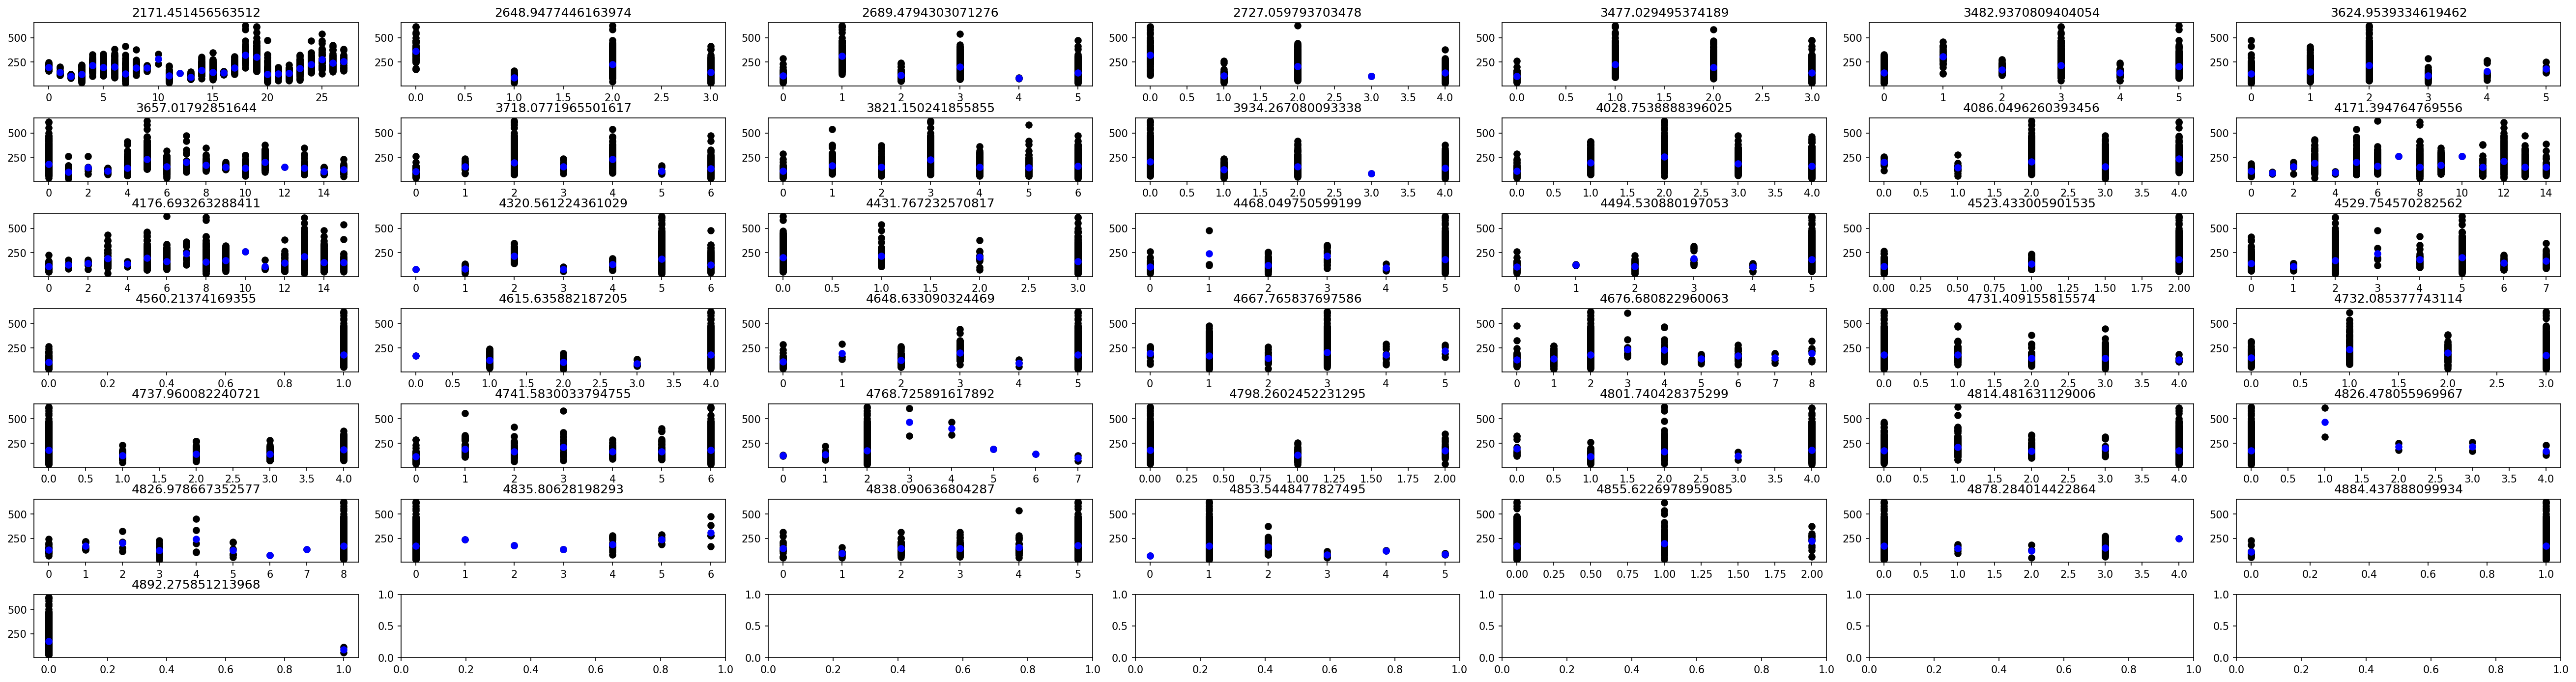

In [ ]:
fig, axs = plt.subplots(7,7, figsize=(35, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

axs = axs.ravel()

for i,j,k in zip(np.arange(X[:, iscat].shape[1]), dictionary_sigma_asc_int, dictionary_sigma_asc):
    axs[i].scatter(X[:, iscat][:, j], X[:, -1], color = 'black')
    axs[i].scatter(np.unique(X[:, iscat][:, j]), dictionary_mu[k], color = 'blue')
    axs[i].set_title(dictionary_sigma[k])

In [ ]:
def beta_o(b_1, y, x):
  beta_o = np.average(y) - b_1 * np.average(x)
  return(beta_o)

def beta_1(y , x):
  y_bar = np.average(y)
  x_bar = np.average(x)

  num = np.sum((y - y_bar) * (x - x_bar)) 
  denom = np.sum(np.square((x - x_bar)))

  beta_1 = num / denom
  
  return(beta_1)

def model(b0, b1, x_new):
  Y = b0 + (b1 * x_new)
  return(Y)

In [ ]:
not_cat = np.logical_not(iscat)

keys_cont = [str(i) for i in range(X[:, not_cat].shape[1])]
values_b0 = []
values_b1 = []
variance_estimate_list = []
y_hat_list = []

for i in range(X[:, not_cat].shape[1]):
  #remove nulls
  mask = np.logical_not(np.isnan(X[:, not_cat][:, i]))
  non_null_X = X[:, not_cat][:, i][mask]
  b1 = beta_1(X[:, -1][mask] , non_null_X)
  b0 = beta_o(b1, X[:, -1][mask], non_null_X)
  values_b0.append(b0)
  values_b1.append(b1)

  y_hat = [model(b0, b1, j) for j in non_null_X]
  y_hat_list.append(y_hat)
  variance_estimate = np.average(np.square(X[:, -1][mask] - y_hat))
  variance_estimate_list.append(variance_estimate)


dictionary_b0 = dict(zip(keys_cont, values_b0))
dictionary_b1 = dict(zip(keys_cont, values_b1))
dictionary_variance_estimate = dict(zip(keys_cont, variance_estimate_list))
dictionary_yhat =  dict(zip(keys_cont, y_hat_list))


In [ ]:
dictionary_variance_asc = sorted(dictionary_variance_estimate, key=dictionary_variance_estimate.get)
dictionary_variance_asc_int = [int(i) for i in dictionary_variance_asc]

print("Variance lowest to highest = ")
for i in dictionary_variance_asc:
  print(dictionary_variance_estimate[i])

Variance lowest to highest = 
0.0
1843.6919810621812
2277.4861094193834
2885.4051241316342
2918.6782651155745
2935.7263255019193
2986.4452397386476
3427.7776286403773
3481.438875175767
3563.9441362356974
3639.8914273552655
3694.159872608878
3706.127208326333
3790.889599249114
3894.96522816942
4306.010356799229
4362.756638347548
4470.414754045677
4480.444505029787
4496.383019092614
4498.649225701078
4530.348326169907
4737.534496731524
4776.200048952503
4829.168048920535
4830.164586453867
4833.7018814728835
4855.8787212079305
4887.007655932726
4891.030814825463
4892.3583764084915
4895.584192617435
4895.73263206027
4897.497464039976
4897.506058963021
4898.521503608298


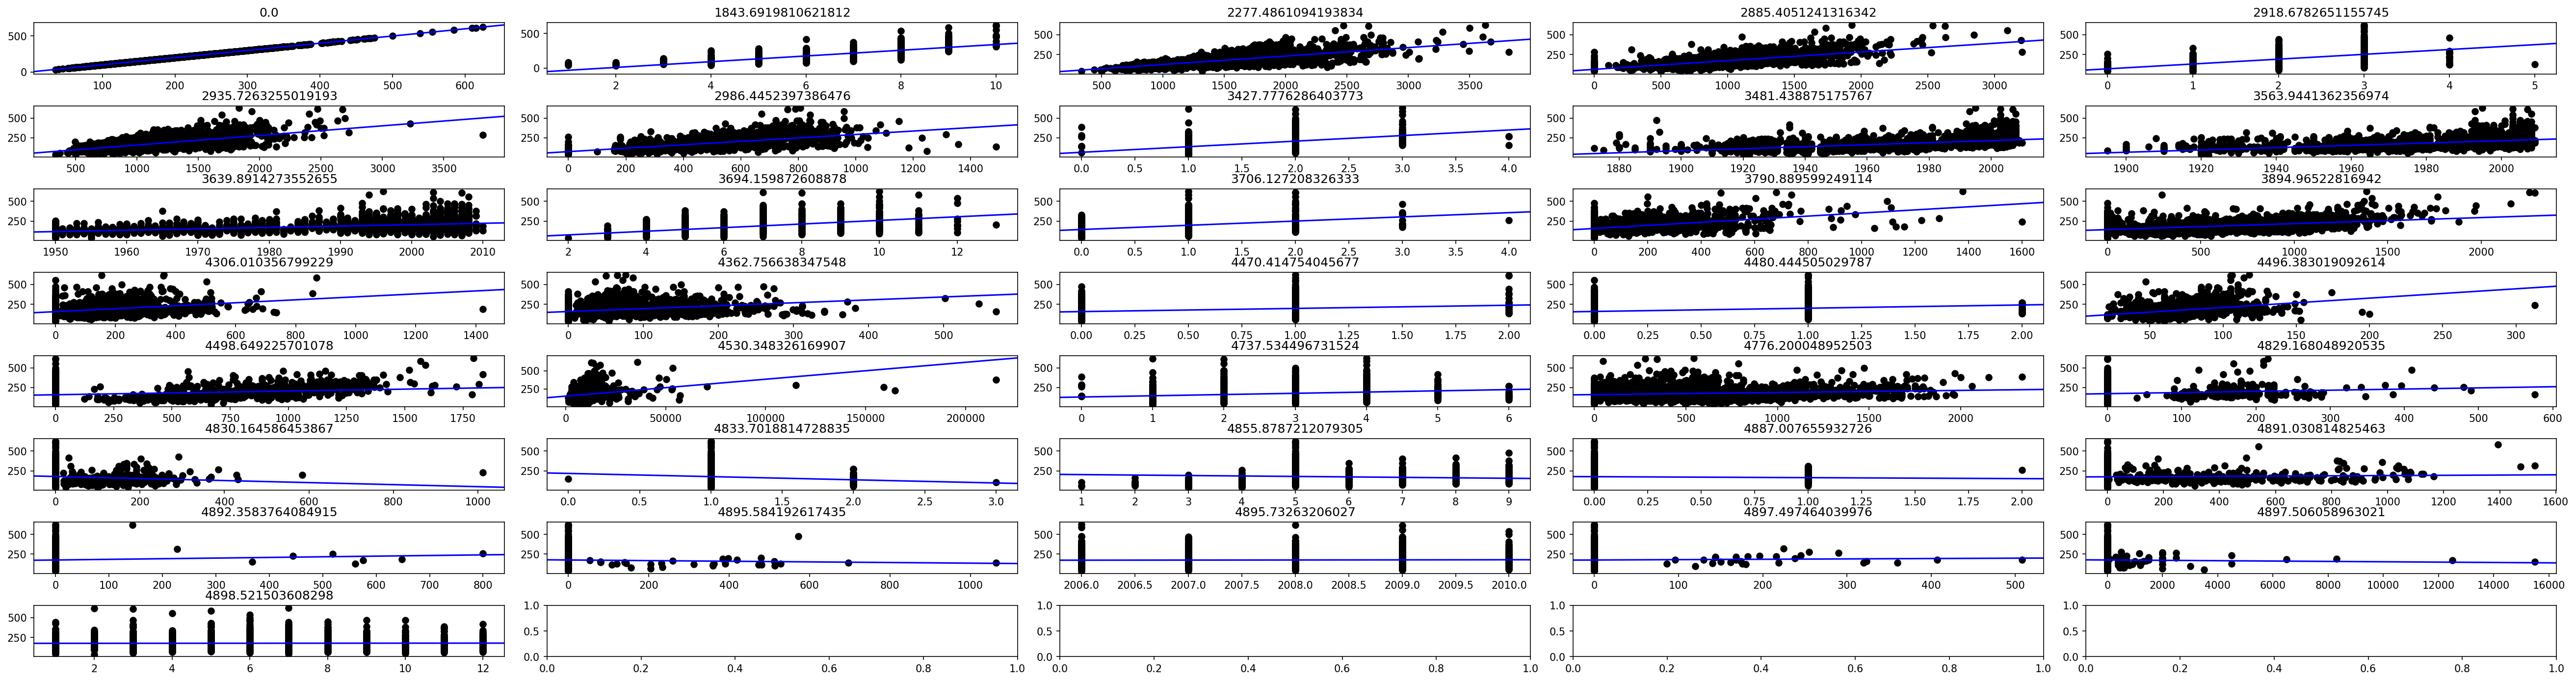

In [ ]:
fig, axs = plt.subplots(8,5, figsize=(35, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

axs = axs.ravel()

for i,j,k in zip(np.arange(X[:, not_cat].shape[1]), dictionary_variance_asc_int, dictionary_variance_asc):
    axs[i].scatter(X[:, not_cat][:, j], X[:, -1], color = 'black')
    plotline(axs[i], dictionary_b1[k], dictionary_b0[k])
    axs[i].set_title(dictionary_variance_estimate[k])

In [ ]:
for i,j in enumerate(featurenames):
  print(i,j)

0 MS SubClass
1 MS Zoning
2 Lot Frontage
3 Lot Area
4 Street
5 Alley
6 Lot Shape
7 Land Contour
8 Utilities
9 Lot Config
10 Land Slope
11 Neighborhood
12 Condition 1
13 Condition 2
14 Bldg Type
15 House Style
16 Overall Qual
17 Overall Cond
18 Year Built
19 Year Remod/Add
20 Roof Style
21 Roof Matl
22 Exterior 1st
23 Exterior 2nd
24 Mas Vnr Type
25 Mas Vnr Area
26 Exter Qual
27 Exter Cond
28 Foundation
29 Bsmt Qual
30 Bsmt Cond
31 Bsmt Exposure
32 BsmtFin Type 1
33 BsmtFin SF 1
34 BsmtFin Type 2
35 BsmtFin SF 2
36 Bsmt Unf SF
37 Total Bsmt SF
38 Heating
39 Heating QC
40 Central Air
41 Electrical
42 1st Flr SF
43 2nd Flr SF
44 Low Qual Fin SF
45 Gr Liv Area
46 Bsmt Full Bath
47 Bsmt Half Bath
48 Full Bath
49 Half Bath
50 Bedroom AbvGr
51 Kitchen AbvGr
52 Kitchen Qual
53 TotRms AbvGrd
54 Functional
55 Fireplaces
56 Fireplace Qu
57 Garage Type
58 Garage Yr Blt
59 Garage Finish
60 Garage Cars
61 Garage Area
62 Garage Qual
63 Garage Cond
64 Paved Drive
65 Wood Deck SF
66 Open Porch SF
67 En

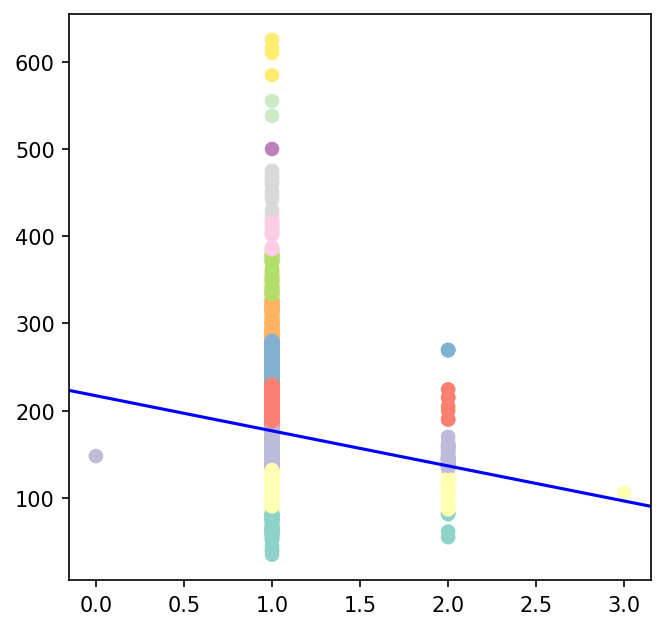

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), facecolor='w', edgecolor='k')
b1 = beta_1(X[:, -1], X[:, 51])
b0 = beta_o(b1, X[:, -1], X[:, 51])

ax.scatter(X[:, 51], X[:, -1], c = X[:, 78], cmap='Set3')
plotline(ax, b1, b0)

Here we look at P(SalesPrice | Kitchen AbvGr), at a holistic level the correlation between Kitchen AbvGr and Sales Price is negative (-40 is the slope) but when we condition on Neighbourhood we see that, Houses with 2 kitchens are from specific neighbourhoods which have low cost in general therefore for these neighbourhoods (see color carefully) the sales price is low. Compared to light green, yellow and purple for which cost is hight. Therefore, if we condition on P(SalesPrice | Kitchen AbvGr, Neighbourhood = light green, yellow and purple) we will get a positive correlation. 
